# ABSTRACT


This blog post seeks to build a model for predicting the species of a given penguin based on features of that penguin, such as flipper length, body mass, or the island they inhabit. Constructing the model is part of a pipeline that begins with data preparation where we remove the target variable, and ensure the columns of the data frame are suitable for model fitting. As part of fitting the model to both the training and test data, cross-validation helps reduce the possibility of the model over fitting to the training data, resulting in poorer performance on the testing data. We can then evaluate and visualize the performance of our model (in this case, we are shooting for 100%) by plotting decision boundaries or by looking at a confusion matrix to affirm our results. 

In [20]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

# DATA PREPARATION

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis = 1)
    df = pd.get_dummies(df, dtype = float)
    return df, y


X_train, y_train = prepare_data(train)

X_train

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,51.1,16.5,225.0,5250.0,8.20660,-26.36863,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
271,35.9,16.6,190.0,3050.0,8.47781,-26.07821,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
272,39.5,17.8,188.0,3300.0,9.66523,-25.06020,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
273,36.7,19.3,193.0,3450.0,8.76651,-25.32426,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0


# EXPLORE: 
Create two visualizations of the data and one summary table.

In [33]:
SumTable = train.groupby(['Species', 'Sex']).aggregate({'Body Mass (g)': 'mean'})
SumTable2 = train.groupby(['Species', 'Island']).aggregate({'Culmen Length (mm)': 'mean'})

In [34]:
SumTable

Body Mass (g)
Species                                   Sex                  
Adelie Penguin (Pygoscelis adeliae)       FEMALE    3350.471698
                                          MALE      4052.868852
Chinstrap penguin (Pygoscelis antarctica) FEMALE    3523.387097
                                          MALE      4005.769231
Gentoo penguin (Pygoscelis papua)         .         4875.000000
                                          FEMALE    4684.693878
                                          MALE      5476.704545

In this summary table, we can see the disparities in body mass between males and females of the same species, as well as between species. Take a look at the female Gentoo penguins. On average, they weigh roughly 1000 grams more than the average female Adele or Chinstrap, signifying penguin Sex might be a favorable feature to include when constructing a model.

In [24]:
SumTable2

Culmen Length (mm)
Species                                   Island                       
Adelie Penguin (Pygoscelis adeliae)       Biscoe              38.975000
                                          Dream               38.501786
                                          Torgersen           38.950980
Chinstrap penguin (Pygoscelis antarctica) Dream               48.833824
Gentoo penguin (Pygoscelis papua)         Biscoe              47.504878

This summary table examines the average culmen length of penguin species on each island. Looking closely, we see that only Adele and Gentoo inhabit Biscoe island and the difference in their average culmen lengths is roughly 9 millimeters. Similarly, only Adelie and Chinstrap live on Dream island, and the average difference in culmen length there is roughly 10 millimeters, a significant amount. 

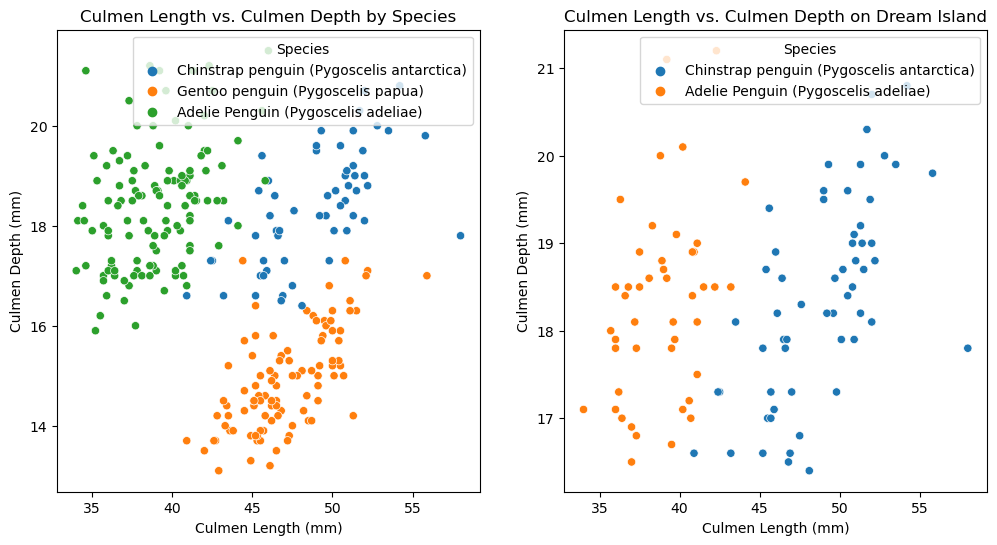

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot first scatterplot
sns.scatterplot(data=train, x='Culmen Length (mm)', y='Culmen Depth (mm)', hue= 'Species', ax=axes[0])
axes[0].set_title('Culmen Length vs. Culmen Depth by Species')

# Plot second scatterplot
# Filter to get penguins living on Dream Island
Island_Dream_df = train[train['Island'] == 'Dream']
sns.scatterplot(x='Culmen Length (mm)', y='Culmen Depth (mm)', data= Island_Dream_df, hue= 'Species', ax=axes[1])
axes[1].set_title('Culmen Length vs. Culmen Depth on Dream Island')

plt.show()

The scatterplot on the left graphs culmen depth vs. culmen length which yields three fairly distinct regions characterized by penguin species, suggesting these two features would be suitable for a model. 

The scatterplot on the right visualizes a trend shown by the summary table which indicates that only Adelie and Chinstrap inhabit Dream Island and the two species are relatively distinguishable by the ratio of the ratio of their culmen length and culmen depth. 

# FEATURE SELECTION: 

The block of code below implements two models: Logistic Regression and Decision Tree Classifier. Iterating through the combinations of the columns, we fit the Logistic Regression model to each combination, and utilize GridSearchCV, a tool for cross-validation that works in junction with the DCF model to find the best parameters for the DCF model (depth). We can then filter the results to find the combinations of features that yield an accuracy of 1.0 from either the Logistic Regression or DCF model. 

In [26]:
from itertools import combinations
import numpy as np

# Alternative tools to select features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Types of models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Optimizing max_depth
from sklearn.model_selection import GridSearchCV

# Cross validation
from sklearn.model_selection import cross_val_score

# Qualitative and quantitative columns I've selected
all_qual_columns = ["Island_Biscoe", "Island_Dream", "Island_Torgersen", "Stage_Adult, 1 Egg Stage","Clutch Completion_No", "Clutch Completion_Yes", "Sex_FEMALE", "Sex_MALE" ]
all_quant_columns = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]

LR = LogisticRegression(max_iter = 1000)  

clf = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth': np.arange(1, 21)}

all_cols = []

for qual in all_qual_columns: 
    qual_cols = [col for col in X_train.columns if qual in col] 
    for pair in combinations(all_quant_columns, 2):
        cols =  list(pair) + qual_cols 

        # Linear Regression Model

        LR.fit(X_train[cols], y_train)
        LR_accuracy = LR.score(X_train[cols], y_train)
        # Cross validation step 
        cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5)

        # Decision Tree Classifier Model

        # Grid search with cross-validation to find the best parameters for the classifier
        grid_search = GridSearchCV(clf, parameters, cv = 5)
        # Fit grid search to training data
        grid_search.fit(X_train[cols], y_train)
        # Gets best estimator (classifier) from the grid search
        best_clf = grid_search.best_estimator_
        best_params = grid_search.best_params_
        # Accuracy of best estimator (classifier) on the training data
        dt_accuracy = best_clf.score(X_train[cols], y_train)
        # Cross validation step
        cv_scores_DecisionTree = cross_val_score(best_clf, X_train[cols], y_train, cv = 5)
        
        # print only the combination of features that produce 100% accuracy
        if (dt_accuracy == 1.0 or LR_accuracy == 1.0):
            print(f"Features: {cols}, LR Accuracy: {LR_accuracy}, DT Accuracy: {dt_accuracy}, Best Params: {best_params}")
        


Features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Dream'], LR Accuracy: 0.99609375, DT Accuracy: 1.0, Best Params: {'max_depth': 5}
Features: ['Body Mass (g)', 'Delta 13 C (o/oo)', 'Island_Dream'], LR Accuracy: 0.82421875, DT Accuracy: 1.0, Best Params: {'max_depth': 8}
Features: ['Culmen Length (mm)', 'Body Mass (g)', 'Sex_FEMALE'], LR Accuracy: 0.97265625, DT Accuracy: 1.0, Best Params: {'max_depth': 7}
Features: ['Culmen Length (mm)', 'Body Mass (g)', 'Sex_MALE'], LR Accuracy: 0.97265625, DT Accuracy: 1.0, Best Params: {'max_depth': 7}


We now have multiple combinations of features we can choose from. As we can see, none of the Logistic Regression models yielded a perfect accuracy of 1.0, but came quite close. 

# TESTING

Taking one of the feature combinations generated by the Decision Tree Classifier that yielded 100% accuracy and using it as the features for the model on the testing data. 

In [27]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test_clf = DecisionTreeClassifier(random_state=0, max_depth= 7)
X_test, y_test = prepare_data(test)   

test_cols = ['Culmen Length (mm)', 'Body Mass (g)', 'Sex_MALE', 'Sex_FEMALE']

test_clf = test_clf.fit(X_test[test_cols], y_test)

Test_score = test_clf.score(X_test[test_cols], y_test)

In [28]:
X_test[test_cols]

,Culmen Length (mm),Body Mass (g),Sex_MALE,Sex_FEMALE
0,41.7,4700.0,0.0,1.0
1,50.7,4050.0,1.0,0.0
2,38.1,3425.0,0.0,1.0
3,39.6,3550.0,0.0,1.0
4,43.3,4400.0,0.0,1.0
...,...,...,...,...
64,42.5,3350.0,0.0,1.0
65,54.3,5650.0,1.0,0.0
66,59.6,6050.0,1.0,0.0
67,36.9,3500.0,0.0,1.0


# PLOTTING DECISION REGIONS

Using code from the Palmer's Penguins blog post, and corresponding lectures, we can plot the decision regions generated from our model. 

In [29]:
from matplotlib.patches import Patch

# plot_regions function borrowed from Palmer's Penguins blog post instructions / lecture
def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches)
      
      plt.tight_layout()

We can now plot the decision regions to visualize where the model classifies points in the data.

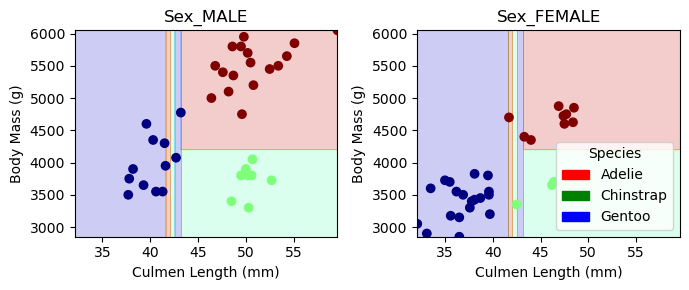

In [30]:
plot_regions(test_clf, X_test[test_cols], y_test)

# CONFUSION MATRIX

In [31]:
from sklearn.metrics import confusion_matrix

y_test_pred = test_clf.predict(X_test[test_cols])
C = confusion_matrix(y_test, y_test_pred)
C

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 26]])

The confusion matrix demonstrates the model correctly identified the members of each penguin species with 100% accuracy. 

# DISCUSSION

In summary, the Decision Tree Classifier model (DTC) using culmen length, body mass, and penguin sex produced 100% accuracy on both the testing and the training data. It is important to recognize, however, that the fitting the model is only one step in the process. Data preparation and safe training practices (cross-validation) are fundamental pieces that work in junction to the fitting of the model on the data. Visualizing the model's outcomes is also an important part of the pipeline as a way to show yourself and others what the classification of the data looks like. 